In [283]:
#Librerias
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score,confusion_matrix
import seaborn as sns

In [284]:
# Se lee la base de datos y se imprimen los datos más relevantes de esta 
dataHeartDisese = pd.read_csv('heart.csv')
print(dataHeartDisese.columns)
dataHeartDisese.head(10)
# Se tienen 11 caracteristicas de las cuales 5 son categoricas y 6 son numericas

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [285]:
#Se separan las columnas categoricas y numericas
Categoricas = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
Numericas = ['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']
#Se buscan valores unicos, es decir, los valores que puede tomar cada categoria.
for col in Categoricas:
    print("La categoria", col, "puede tomar los valores de:",dataHeartDisese[col].unique())

print(Numericas)

La categoria Sex puede tomar los valores de: ['M' 'F']
La categoria ChestPainType puede tomar los valores de: ['ATA' 'NAP' 'ASY' 'TA']
La categoria RestingECG puede tomar los valores de: ['Normal' 'ST' 'LVH']
La categoria ExerciseAngina puede tomar los valores de: ['N' 'Y']
La categoria ST_Slope puede tomar los valores de: ['Up' 'Flat' 'Down']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']


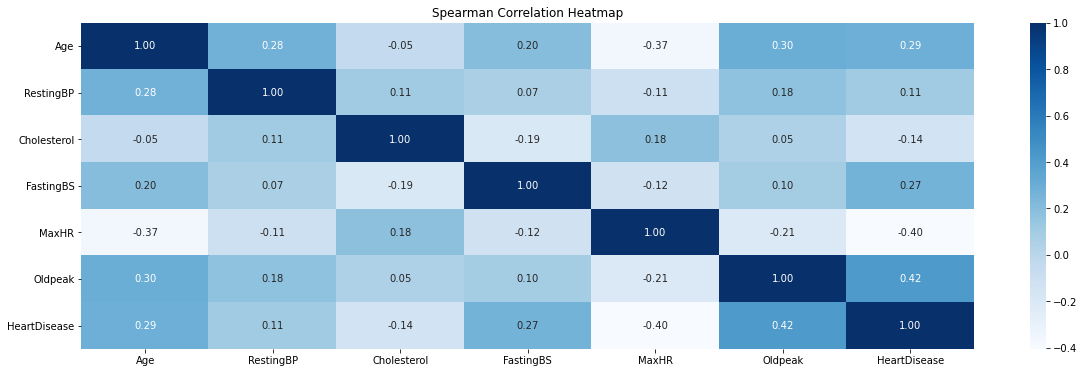

In [286]:
corr = dataHeartDisese.corr(method = 'spearman')
plt.figure(figsize=(20,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Spearman Correlation Heatmap')
plt.show()


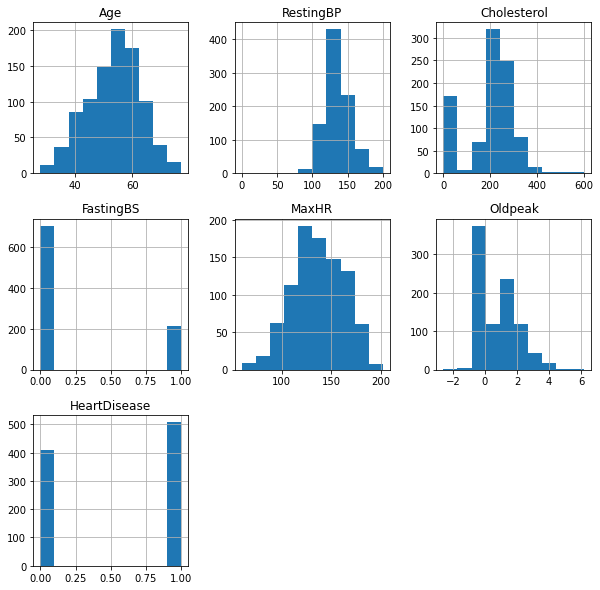

In [287]:
dataHeartDisese.hist(figsize=(10,10))
plt.show()
# Se observa en el Histograma que en la columna de Colesterol hay muchos valores fuera de tendencia sobre cero
#  esto puede ser que son datos que fueron perdidos y se remplazaron por cero

In [288]:
# Para facilitar el trabajo no se trabajara con la Columna de Cholesterol, muchos valores fuera de tendencia dificultan la predicción.
Numericas.remove('Cholesterol')
# Se procede a remplazar los valores categoricos por valores numericos, dado que no tienen orden se eligen numeros enteros consecutivos
# M ---> 0 F ---> 1
# N ---> 0 Y ---> 1
# Up --> 0 Flat --> 1 Down --> 2
# Normal --> 0 ST --> 1 LVH--> 2
# ATA --> 0 NAP --> 1 ASY --> 2 TA --> 2

cat_binarias = { "Sex": {"M": 0, "F": 1},
                 "ExerciseAngina": {"N": 0,"Y": 1},
                 "ChestPainType": {"ATA": 0,"NAP": 1,"ASY": 2,"TA":2},
                 "ST_Slope": {"Up": 0,"Flat": 1,"Down": 2},
                 "RestingECG": {"Normal": 0,"ST": 1,"LVH": 2}}

Categoricas = dataHeartDisese.replace(cat_binarias)
Categoricas.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,0,140,289,0,0,172,0,0.0,0,0
1,49,1,1,160,180,0,0,156,0,1.0,1,1
2,37,0,0,130,283,0,1,98,0,0.0,0,0
3,48,1,2,138,214,0,0,108,1,1.5,1,1
4,54,0,1,150,195,0,0,122,0,0.0,0,0


In [289]:
#Con los valores ya limpios se divide la base de datos en etiqueta de salida y caracteristicas
etiqueta = dataHeartDisese.iloc[:,11].values
caracteristicas = Categoricas.iloc[:,:11].values
print(etiqueta.shape)
print(caracteristicas.shape)


(918,)
(918, 11)


In [290]:
#Se divide la base de datos en datos de entrenamiento(80%) y datos de validación(20%) 
car_train,car_test,etiq_train,etiq_test = train_test_split (caracteristicas,etiqueta,test_size=0.2)
print("Train: ",car_train.shape, etiq_train.shape)
print("Test: ",car_test.shape, etiq_test.shape)

Train:  (734, 11) (734,)
Test:  (184, 11) (184,)


In [291]:
# Escalizar los datos 
sc = StandardScaler()
car_train = sc.fit_transform(car_train)
car_test = sc.transform(car_test)

In [294]:
# Se definen algunas funciones para facilitar la comparación de los resultados de los modelos
# Para optimizar los hiperparametros se hace un Grid Search, 

def Optimize(classifier, params,X_train, y_train, cv=10 ):
    grid = GridSearchCV(classifier, params, cv=KFold(n_splits=cv), n_jobs=1, verbose=1, return_train_score=True, scoring='accuracy', refit=True) 
    grid.fit(X_train, y_train)
    return grid

# De la funcion de GridSearch también se extraen los mejores puntajes obtenidos y los mejores parametros.
def best_scores(model):
    print(f'Los mejores parametros obtenidos son {model.best_params_}')
    print(f'El mejor puntaje de accuracy obtenido es:{model.best_score_}')

# Se crea un funcion que imprime en el terminal las métricas usadas F1,ROC-AUC SCORE Y MCC
def metrics(y_pred,y_test):
    print("El puntaje F1 :", f1_score(y_test, y_pred))
    print("El puntaje ROC-AUC:",roc_auc_score(y_test,y_pred))
    print("El coeficien de correlación de Matthews:",matthews_corrcoef(y_test,y_pred))
    
def plot_confusion_matrix(y_pred,y_test):
    print('00: True Negatives\n01: False Positives\n10: False Negatives\n11: True Positives\n')
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap='GnBu', alpha=0.75)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large') 
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()
    



In [299]:
lr_params = {'C':[0.001,.009,0.01,.09,0.9,1,9,10,9], 'penalty':['l1', 'l2']} #lasso and ridge regression
clf = LogisticRegression(random_state=100, solver='liblinear', max_iter=1000000)
lr_model = Optimize(clf, lr_params,car_train,etiq_train)
best_scores(lr_model)
etiq_pred=lr_model.predict(car_test)
metrics(etiq_pred,etiq_test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Los mejores parametros obtenidos son {'C': 0.09, 'penalty': 'l2'}
El mejor puntaje de accuracy obtenido es:0.8378748611625324
El puntaje F1 : 0.9056603773584906
El puntaje ROC-AUC: 0.8918128654970761
El coeficien de correlación de Matthews: 0.7783334561490105


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



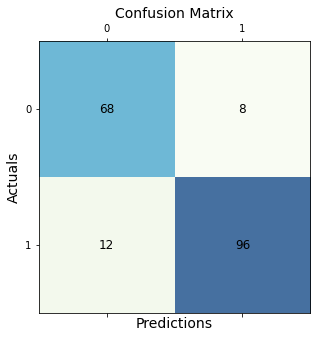

In [300]:
plot_confusion_matrix(etiq_pred,etiq_test)